In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import scipy.stats as sts
from scipy import stats
from statsmodels.stats.diagnostic import  het_breuschpagan, het_white
import seaborn as sns

In [2]:
data  = pd.read_csv('chocolate_data.csv') 

In [3]:
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()

In [4]:
data

,name,price,is_sugar_first,palm,weight,rus_brand,rating,no_sugar,kcal,package,type,cocoa,filling_NUTS,filling_BERRIES,filling_SNACKS,filling_DESSERT,filling_EXOTIC,food_additives
0,Шоколад белый Миндаль и кокос Alpen Gold 80г,74.99,1,0,80.0,1,4.8,0,545.0,Флоупак,Белый,22.0,1,0,0,0,1,1
1,Шоколад белый пористый Россия щедрая душа 75г,74.99,1,0,75.0,1,4.8,0,545.0,Флоупак,Белый,25.0,0,0,0,0,0,1
2,Шоколад Классический Чизкейк Alpen Gold 85/90г,74.99,1,1,85.0,1,4.8,0,533.0,Флоупак,Молочный,25.0,0,0,0,1,0,1
3,Шоколад молочный Россия щедрая душа 82г,79.99,1,0,82.0,1,4.8,0,539.0,Флоупак,Молочный,27.0,0,0,0,0,0,1
4,Шоколад белый Gold Selection Дуэт в клубнике Р...,88.99,1,0,85.0,1,4.8,0,543.0,Флоупак,Белый,20.0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,Шоколад Альпийский молочный с фундуком Schoget...,149.99,1,0,100.0,0,4.8,0,574.0,Kартон,Молочный,30.0,1,0,0,0,0,0
159,Шоколад Белый Цельный лесной орех и хлопья Rit...,189.99,1,0,100.0,0,4.9,0,570.0,Флоупак,Белый,20.0,1,0,1,0,0,0
160,Шоколад молочный с кусочками малины Bucheron V...,239.99,1,0,100.0,1,4.9,0,540.0,Kартон,Молочный,33.0,0,1,0,0,0,0
161,Шоколад начинка кусочки соленого кешью Ritter ...,186.99,1,0,100.0,0,4.8,0,539.0,Флоупак,Молочный,50.0,1,0,0,0,0,0


# Проверка на наличие выбросов:


Воспльзуемся двумя критериями: стьюдентизированные остатки, DFFITS

## Стьюдентизированный остаток

Стьюдентизированный остаток --- это остаток, деленный на свое стандартное отклонение при условии исключения данного наблюдения, т.е.

$$e'_i = \frac{e_i}{S(i)\sqrt{1-h_i}}$$

где:
- $e_i$ --- остаток для конкретного наблюдения, полученный по уравнению регрессии, построенному с учетом всех наблюдений;
- $S(i)$ --- стандартное отклонение остатков, полученное по уравнению регрессии, построенному по тому же набору наблюдений, но без учета наблюдения $i$;
- $h_i$ --- это диагональный элемент матрицы проектора $X(X'X)^{-1}X'$.

Решающее правило:

> Если $e_i' \notin [-t_{crit},t_{crit}], \ t_{crit} = t_{1-\alpha, n-k}$, где n - количество наблюдений, k - количество регрессоров c учетом константы $\Rightarrow$ выброс

## DFFITS

$$DFFIT_i = \hat{Y}_i - \widehat{Y_{i(i)}},$$

где $\hat{Y}_i$ и $\widehat{Y_{i(i)}}$ -- это предсказанные по модели значения с учетом и без учета наблюдения $i$.

$$DFFITS_i = e'_i\sqrt{\frac{h_i}{1-h_i}},$$

где $e'_i$ -- стьюдентизированный остаток.

Если $DFFITS_i > 2\sqrt{\frac{k}{n}}$, то $i$-е наблюдение может быть выбросом,

где $k$ -- это число регрессоров, а $n$ -- это число наблюдений.


In [5]:

formula = 'price ~ weight + is_sugar_first + palm + kcal + rating +cocoa + rus_brand + no_sugar + package + type + filling_NUTS +  filling_BERRIES + filling_SNACKS + filling_DESSERT + filling_EXOTIC + food_additives'

model = smf.ols(formula=formula, data=data).fit()


In [6]:

influence = model.get_influence()
influence_summary = influence.summary_frame()


p = len(model.params) 
n = len(data)          
standard_threshold = 2 * np.sqrt(p/n)


dffits_abs = abs(influence_summary['dffits'])
student_resid = influence_summary['standard_resid']
alpha = 0.05

t_quantile = sts.t.ppf(1 - alpha/2, n - p)
is_outl = np.where(np.abs(student_resid)>t_quantile,1,0)

is_outlier = pd.Series(is_outl, index=influence_summary.index)


outliers_count = is_outlier.sum()



print(f"\nОбнаружено {outliers_count} выбросов")


high_dffits = influence_summary[abs(influence_summary['dffits']) > standard_threshold]
high_dffits_count = len(high_dffits)
high_dffits_indices = high_dffits.index.tolist()

print(f"\nКоличество наблюдений с критическим |DFFITS|: {high_dffits_count} ")


mask = influence_summary.index.isin(high_dffits_indices)
outlier_indices = is_outlier[is_outlier == 1].index


dffits_outliers = set(high_dffits_indices)
studentized_outliers = set(outlier_indices)


common_outliers = dffits_outliers.intersection(studentized_outliers)
outlier_records = data.loc[list(common_outliers)]
print("Записи, определенные как выбросы по обоим критериям:")
(outlier_records)






Обнаружено 12 выбросов

Количество наблюдений с критическим |DFFITS|: 15 
Записи, определенные как выбросы по обоим критериям:


,name,price,is_sugar_first,palm,weight,rus_brand,rating,no_sugar,kcal,package,type,cocoa,filling_NUTS,filling_BERRIES,filling_SNACKS,filling_DESSERT,filling_EXOTIC,food_additives
129,Шоколад горький Bucheron Standart 72% 100г,359.99,0,0,100.0,1,4.9,0,514.0,Kартон,Горький,72.0,0,0,0,0,0,0
100,Шоколад Red Delight Темный с апельсином и минд...,219.99,0,0,100.0,1,4.8,1,305.0,Kартон,Темный,40.0,1,0,0,0,1,1
101,Шоколад Ozera горький без сахара с апельсином 90г,174.99,0,0,90.0,1,4.8,1,470.0,Kартон,Горький,67.0,0,0,0,0,1,0
134,Шоколад горький с фундуком Bucheron Standart 100г,359.99,0,0,100.0,1,4.9,1,534.0,Kартон,Горький,72.0,1,0,0,0,0,0
138,Шоколад со злаками Kinder Chocolate 4шт*23.5г,239.99,1,0,94.0,0,4.9,0,561.0,Флоупак,Молочный,13.0,0,0,1,0,0,0
107,Шоколад Ozera горький без сахара с фундуком 90г,174.99,0,0,90.0,1,4.8,1,510.0,Kартон,Горький,67.0,1,0,0,0,0,0
142,Шоколад молочный с кусочками малины Bucheron S...,329.99,1,0,100.0,1,4.9,0,544.0,Kартон,Молочный,5.0,0,1,0,0,0,0
17,Шоколад молочный с лесным орехом Степ 90г,45.99,1,0,100.0,1,4.7,0,497.0,Флоупак,Молочный,35.0,1,0,0,0,0,1
20,Шоколад молочный с начинкой Степ 90г,45.99,1,0,100.0,1,4.8,0,491.0,Флоупак,Молочный,35.0,1,0,1,0,0,1
23,Шоколад горький 70% Российский 82г,74.99,0,0,82.0,1,4.8,0,569.0,Флоупак,Горький,70.0,0,0,0,0,0,0


In [7]:
print(f"\nБыло удалено : {len(common_outliers)} выбросов ")
data = data[~data.index.isin(common_outliers)].copy()


Было удалено : 12 выбросов 


In [8]:
data['no_sugar'].sum()

np.int64(0)

В ходе исследования оба метода выделили 12 аномальных наблюдений, которые были удалены из датасета для дальнейшего анализа.

При исследовании выбросов, идентифицированных с помощью методов DFFITS и стьюдентизированных остатков, была выявлена систематическая закономерность: все наблюдения с характеристикой 'no_sugar' оказались классифицированы как выбросы, было принято методологически обоснованное решение исключить переменную 'no_sugar' из набора факторов для оценивания модели на очищенной выборке.

## Проверка гипотезы о нормальности остатков:

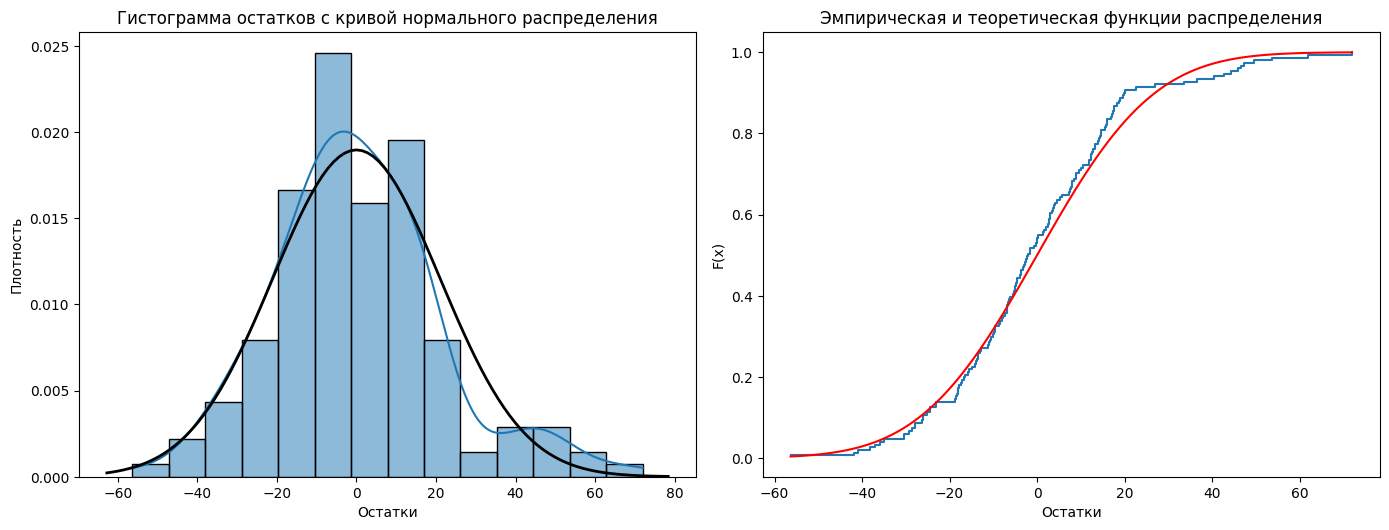

In [9]:

formula = 'price ~ weight + is_sugar_first + palm + kcal + rating +cocoa + rus_brand + package + type + filling_NUTS +  filling_BERRIES + filling_SNACKS + filling_DESSERT + filling_EXOTIC + food_additives'

model = smf.ols(formula=formula, data=data).fit()
residuals = model.resid

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.histplot(residuals, kde=True, stat="density")
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(residuals), np.std(residuals))
plt.plot(x, p, 'k', linewidth=2)
plt.title('Гистограмма остатков с кривой нормального распределения')
plt.xlabel('Остатки')
plt.ylabel('Плотность')

plt.subplot(2, 2, 2)
sorted_residuals = np.sort(residuals)
ecdf = np.arange(1, len(residuals) + 1) / len(residuals)
plt.step(sorted_residuals, ecdf, where='post')

x_norm = np.linspace(min(residuals), max(residuals), 100)

y_norm = stats.norm.cdf(x_norm, np.mean(residuals), np.std(residuals))
plt.plot(x_norm, y_norm, 'r-')

plt.title('Эмпирическая и теоретическая функции распределения')
plt.xlabel('Остатки')
plt.ylabel('F(x)')

plt.tight_layout()
plt.show()




In [ ]:

jb_stat, jb_p = stats.jarque_bera(residuals)
jb_p = round(jb_p, 3)

mu, sigma = np.mean(residuals), np.std(residuals)
ks_stat, ks_p = stats.kstest(residuals, 'norm', args=(mu, sigma))
ks_p = round(ks_p, 3)
normality_results   = pd.DataFrame({
    'Тест': ['Тест Хархе - Бера', 'Тест Колмогорова - Смирнова'],
    'P-value': [ jb_p, ks_p],
    'Вывод': [
        'Остатки не распределены нормально' if jb_p < alpha else 'Остатки распределены нормально',
        'Остатки не распределены нормально' if ks_p < alpha else 'Остатки распределены нормально'
    ]
})


residuals = model.resid
print("\nРезультаты тестов:")

(normality_results)


Результаты тестов:


,Тест,P-value,Вывод
0,Тест Хархе - Бера,0.072,Остатки распределены нормально
1,Тест Колмогорова - Смирнова,0.301,Остатки распределены нормально


## Выбор функциональной формы

# PE тест МакКиннона, Уайта и Дэвидсона (1983)

 Шаг 1. Вычисляют
$$\hat{Y} = \hat{\alpha} + \hat{\beta}X \quad и \quad
 \widehat{lnY} = \hat{\alpha} + \hat{\beta}X$$

Шаг 2. Оценивают вспомогательные регрессии

$$\ln Y = \alpha + \beta X + \delta_{LOG} \left( \hat{Y} - \exp(\widehat{lnY}) \right) + \varepsilon$$

$$Y = \alpha + \beta X + \delta_{LIN} \left( \widehat{lnY} - \ln \hat{Y} \right) + \varepsilon$$

 Шаг 3. Проверяют в них гипотезы
$$H_0: \delta_{LOG} = 0 \quad \text{и} \quad H'_0: \delta_{LIN} = 0$$

In [11]:


formula = 'price ~ weight + is_sugar_first + palm + kcal + rating +cocoa + rus_brand +  package + type + filling_NUTS +  filling_BERRIES + filling_SNACKS + filling_DESSERT + filling_EXOTIC + food_additives'
model = smf.ols(formula=formula, data=data).fit()

y_hat = model.predict(data)

linear_model = smf.ols(formula= formula, data=data).fit()
y_hat_linear = linear_model.predict(data)

data['lnprice'] = np.log(data['price'])
formula_log =  'lnprice ~ weight + is_sugar_first + palm + kcal + rating +cocoa + rus_brand +  package + type + filling_NUTS +  filling_BERRIES + filling_SNACKS + filling_DESSERT + filling_EXOTIC + food_additives'
log_model = smf.ols(formula=formula_log, data=data).fit()
ln_y_hat = log_model.predict(data)


data['Y_hat'] = y_hat_linear
data['lnY_hat'] = ln_y_hat
data['exp_lnY_hat'] = np.exp(ln_y_hat)
data['PE_LOG_var'] = data['Y_hat'] - data['exp_lnY_hat']
data['PE_LIN_var'] = data['lnY_hat'] - np.log(data['Y_hat'])


formula_pe_log = "lnprice ~  weight + is_sugar_first + palm + kcal + rating +cocoa + rus_brand +  package + type + filling_NUTS +  filling_BERRIES + filling_SNACKS + filling_DESSERT + filling_EXOTIC + food_additives + PE_LOG_var"
pe_log_model = smf.ols(formula= formula_pe_log, data=data).fit()

formula_pe_lin = "lnprice ~  weight + is_sugar_first + palm + kcal + rating +cocoa + rus_brand +  package + type + filling_NUTS +  filling_BERRIES + filling_SNACKS + filling_DESSERT + filling_EXOTIC + food_additives + PE_LIN_var"
pe_lin_model = smf.ols(formula= formula_pe_lin, data=data).fit()
results = pd.DataFrame({
        'Спецификация': ['Логарифмическая (H0: δ_LOG = 0)', 'Линейная (H0: δ_LIN = 0)'],
        'Коэффициент': [pe_log_model.params['PE_LOG_var'], pe_lin_model.params['PE_LIN_var']],
        'Станд. ошибка': [pe_log_model.bse['PE_LOG_var'], pe_lin_model.bse['PE_LIN_var']],
        't-статистика': [pe_log_model.tvalues['PE_LOG_var'], pe_lin_model.tvalues['PE_LIN_var']],
        'p-значение': [pe_log_model.pvalues['PE_LOG_var'], pe_lin_model.pvalues['PE_LIN_var']]
    })
    

results['Вывод'] = results['p-значение'].apply(
    lambda p: 'Не отвергаем H0. Спецификация приемлема.' if p >= 0.05 
                else 'Отвергаем H0. Спецификация не подходит.'
)

print("\nРезультаты тестов:")

results



Результаты тестов:


,Спецификация,Коэффициент,Станд. ошибка,t-статистика,p-значение,Вывод
0,Логарифмическая (H0: δ_LOG = 0),0.007672,0.002140,3.585149,0.000474,Отвергаем H0. Спецификация не подходит.
1,Линейная (H0: δ_LIN = 0),-0.528267,0.277883,-1.901044,0.059493,Не отвергаем H0. Спецификация приемлема.


# Проверка гипотез о правильной спецификации модели

## Гипотезы:
- $H_0$: спецификация исходной модели является правильной;
- $H_1$: спецификация исходной модели является неправильной.

## Модель основной регрессии:
$$Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_k X_k + \varepsilon$$

## Этапы проверки:

### 1. Построение основной модели

### 2. Сохранение столбца оценённых значений $\hat{Y}$

### 3. Оценка коэффициентов вспомогательной регрессии:

Вспомогательная регрессия строится с использованием предсказанных значений $\hat{Y}$ основной модели и дополнительных переменных:
$$Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_k X_k + \alpha_1 \hat{Y}^2 + u$$

### 4. Проверка гипотез:
- $H_0: \alpha_2 = 0$ (модель правильно специфицирована)
- $H_1: \alpha_2 \neq 0$

## Тестовая статистика

Тестовая статистика при справедливости нулевой гипотезы имеет вид:
$$F = \frac{\left( \frac{RSS_R - RSS_{UR}}{m-1} \right)}{\left( \frac{RSS_{UR}}{n - k} \right)} \sim F(m-1, n-k)$$

где:
- $RSS_R$ — сумма квадратов остатков от ограниченной модели
- $RSS_{UR}$ — сумма квадратов остатков от неограниченной модели (с включённым квадратом $\hat{Y}^2$)
- $m = 1$ — количество коэффициентов, которые проверяются
- $n$ — количество наблюдений
- $k = 6$ — количество параметров в ограниченной модели (с учётом константы)

In [12]:
from statsmodels.stats.diagnostic import linear_reset
reset_test = linear_reset(model, power=2)  

print(f" P- value для теста Рамсея: {reset_test.pvalue:.3f}")

 P- value для теста Рамсея: 0.495


## Проверка на мультиколлинеарность

Проверим с помощью рассчета VIF для числовых признаков:
 VIF -- variance inflation factor, превышает 10

$$\mathbf{VIF}(X_j) = \frac{1}{1-R_j^2}$$

где $R_j^2$ -- коэффициент множественной детерминации регрессора $X_j$ на все остальные регрессоры.

In [13]:
def variance_inflation_factor(column, columns, data):
    formula = str(column) + ' ~ '
    for col in columns:
        if col == column:
            continue
        formula += (col + ' + ')
    formula = formula[:-3]
    model = smf.ols(formula=formula, data=data).fit()
    return 1 / (1 - model.rsquared)

In [14]:
columns = ['is_sugar_first', 'palm', 'weight', 'rus_brand', 'rating', 'no_sugar', 'kcal', 'package', 'type', 'cocoa', 'filling_NUTS', 'filling_BERRIES', 'filling_SNACKS', 'filling_DESSERT', 'filling_EXOTIC', 'food_additives']

In [15]:

data_encoded = pd.get_dummies(data, columns=['type', 'package'], prefix=['type', 'package'], dtype=int)

columns = ['is_sugar_first', 'palm', 'weight', 'rus_brand',
       'rating', 'no_sugar', 'kcal', 'cocoa', 'filling_NUTS',
       'filling_BERRIES', 'filling_SNACKS', 'filling_DESSERT',
       'filling_EXOTIC', 'food_additives', 'type_Горький',
       'type_Молочный', 'type_Темный', 'package_Бумага',
       'package_Флоупак']

data_encoded = data_encoded[columns]
numeric_columns = data_encoded.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns.remove('no_sugar')
X = data_encoded[numeric_columns].copy()
for i, column in enumerate(X.columns):
    if  column!= 'price': 
        vif = variance_inflation_factor(column, columns, data_encoded)
        print(f'VIF для регрессора {column}: {vif:.4f}')

VIF для регрессора is_sugar_first: 4.5501
VIF для регрессора palm: 1.5976
VIF для регрессора weight: 2.2540
VIF для регрессора rus_brand: 2.1960
VIF для регрессора rating: 1.2902
VIF для регрессора kcal: 1.4832
VIF для регрессора cocoa: 8.5778
VIF для регрессора filling_NUTS: 1.2524
VIF для регрессора filling_BERRIES: 1.1367
VIF для регрессора filling_SNACKS: 1.4455
VIF для регрессора filling_DESSERT: 1.3709
VIF для регрессора filling_EXOTIC: 1.2674
VIF для регрессора food_additives: 1.6195
VIF для регрессора type_Горький: 8.8548
VIF для регрессора type_Молочный: 3.9269
VIF для регрессора type_Темный: 6.1622
VIF для регрессора package_Бумага: 1.8718
VIF для регрессора package_Флоупак: 2.1641


# Проверка гипотезы о несистематичности случайных ошибок.


Результаты проверки гипотезы о матожидании случайной ошибки:
Среднее значение остатков: -0.000000
Стандартная ошибка: 1.705532
95% доверительный интервал: [-3.405987, 3.351425]
t-статистика: -0.0000
p-value: 1.000000
Нет оснований отвергать нулевую гипотезу о равенстве матожидания ошибки нулю.
Предпосылка о несистематичности случайной ошибки выполняется.


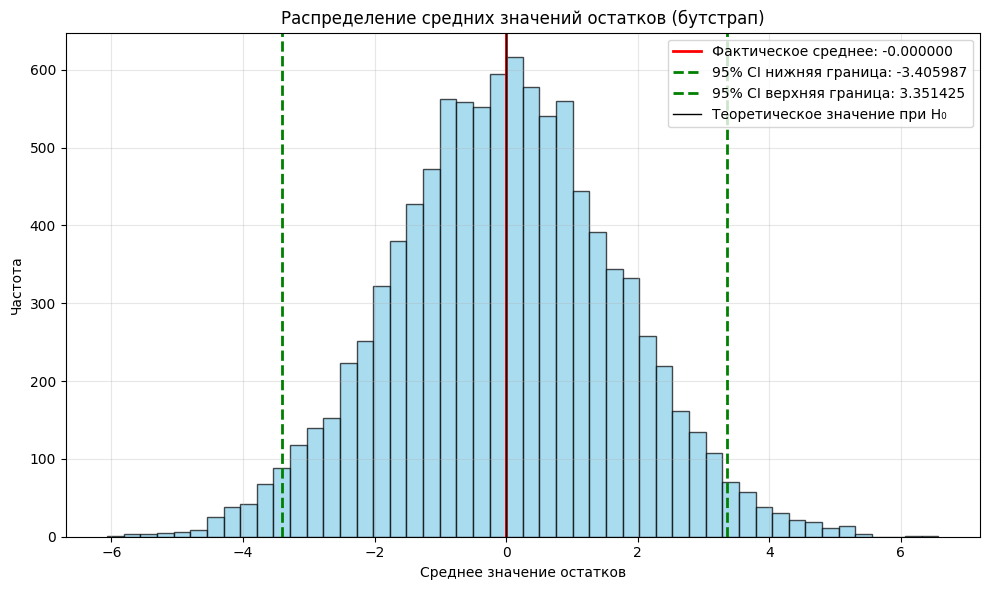

In [16]:

residuals = model.resid


residuals_array = np.array(residuals)
mean_residual = np.mean(residuals_array)
n_bootstrap = 10000
bootstrap_means = []

for i in range(n_bootstrap):

    bootstrap_indices = np.random.choice(len(residuals_array), size=len(residuals_array), replace=True)
    bootstrap_sample = residuals_array[bootstrap_indices]
    
    bootstrap_mean = np.mean(bootstrap_sample)
    bootstrap_means.append(bootstrap_mean)


bootstrap_means = np.array(bootstrap_means)


std_error = np.std(bootstrap_means)

ci_lower = np.percentile(bootstrap_means, 2.5)
ci_upper = np.percentile(bootstrap_means, 97.5)

t_stat = mean_residual / std_error
p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))


print(f"\nРезультаты проверки гипотезы о матожидании случайной ошибки:")
print(f"Среднее значение остатков: {mean_residual:.6f}")
print(f"Стандартная ошибка: {std_error:.6f}")
print(f"95% доверительный интервал: [{ci_lower:.6f}, {ci_upper:.6f}]")
print(f"t-статистика: {t_stat:.4f}")
print(f"p-value: {p_value:.6f}")

if p_value < 0.05:
    print("Нулевая гипотеза о равенстве матожидания ошибки нулю отвергается на уровне значимости 5%.")
    print("Предпосылка о несистематичности случайной ошибки нарушена.")
else:
    print("Нет оснований отвергать нулевую гипотезу о равенстве матожидания ошибки нулю.")
    print("Предпосылка о несистематичности случайной ошибки выполняется.")


plt.figure(figsize=(10, 6))
plt.hist(bootstrap_means, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(mean_residual, color='red', linestyle='-', linewidth=2, 
            label=f'Фактическое среднее: {mean_residual:.6f}')
plt.axvline(ci_lower, color='green', linestyle='--', linewidth=2, 
            label=f'95% CI нижняя граница: {ci_lower:.6f}')
plt.axvline(ci_upper, color='green', linestyle='--', linewidth=2, 
            label=f'95% CI верхняя граница: {ci_upper:.6f}')
plt.axvline(0, color='black', linestyle='-', linewidth=1, 
            label='Теоретическое значение при H₀')
plt.title('Распределение средних значений остатков (бутстрап)')
plt.xlabel('Среднее значение остатков')
plt.ylabel('Частота')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('bootstrap_residual_means.png', dpi=300)
plt.show()


## Проверка гетероскедастичности

Text(0.5, 1.0, 'Остатки vs Предсказанные значения')

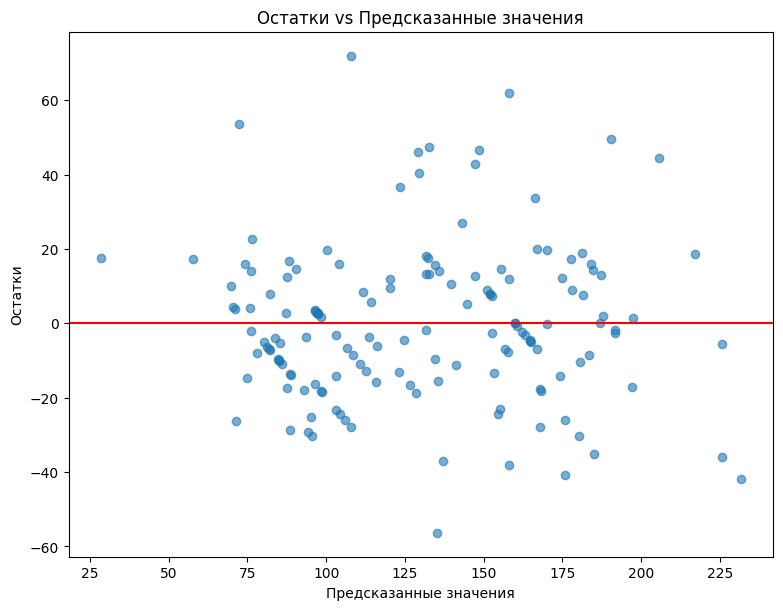

In [17]:

plt.figure(figsize=(20, 15))

plt.subplot(2, 2, 1)
plt.scatter(model.predict(), model.resid, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Остатки vs Предсказанные значения')

In [18]:
residuals = model.resid
X = model.model.exog
    

bp_test = het_breuschpagan(residuals, X)
bp_statistic = bp_test[0]
bp_pvalue = bp_test[1]
bp_conclusion = "Гипотеза о гомоскедостичности отвергается" if bp_pvalue < 0.05 else "Гипотеза о гомоскедастичности не отвергается"


white_test = het_white(residuals, X)
white_statistic = white_test[0]
white_pvalue = white_test[1]
white_conclusion = "Гипотеза о гомоскедостичности отвергается " if white_pvalue < 0.05 else "Гипотеза о гомоскедастичности не отвергается"


results = pd.DataFrame({
    'Тест': ['Тест Бройша - Пагана', 'Тест Уайта'],
    'Статистика': [bp_statistic.round(3), white_statistic.round(3)],
    'p-value': [bp_pvalue.round(3), white_pvalue.round(3)],
    'Вывод': [bp_conclusion, white_conclusion]
})
results

,Тест,Статистика,p-value,Вывод
0,Тест Бройша - Пагана,14.729,0.680,Гипотеза о гомоскедастичности не отвергается
1,Тест Уайта,150.918,0.418,Гипотеза о гомоскедастичности не отвергается


## Оценка итоговой модели:


In [19]:
formula = 'price ~ weight + is_sugar_first + palm + kcal + rating +cocoa + rus_brand +  package + type + filling_NUTS +  filling_BERRIES + filling_SNACKS + filling_DESSERT + filling_EXOTIC + food_additives'

model = smf.ols(formula=formula, data=data).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     27.97
Date:                Thu, 08 May 2025   Prob (F-statistic):           2.16e-36
Time:                        19:14:29   Log-Likelihood:                -674.30
No. Observations:                 151   AIC:                             1387.
Df Residuals:                     132   BIC:                             1444.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -406.6894    103